### Logistic Baseline Model

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# train_path = "s3://sagemaker-us-east-1-381492296191/cardio_data/cardio_train_split40.csv" # Prema's Path
train_path = "s3://sagemaker-us-east-1-226675648827/cardio_data/cardio_train_split40.csv" # Thai's Path

df_train = pd.read_csv(train_path)

print(df_train.shape)
df_train.head()

(27355, 24)


,age,height_ft,weight_lbs,systolic_bp,diastolic_bp,cholesterol,gluc,smoke,alco,active,...,age_years,is_hypertensive,age_gluc_interaction,lifestyle_score,gender,bp_category,bmi_category,age_group,cholesterol_label,cardio
0,-1.156505,1.211180,1.029745,-1.631142,-1.230145,-0.538657,-0.390761,-0.312731,-0.23822,0.494625,...,-1.156505,-0.607947,-0.604684,-0.596864,0.0,1.0,2.0,1.0,1.0,0
1,-1.748550,-0.323580,-0.983384,-0.410657,-0.147087,-0.538657,-0.390761,3.197635,-0.23822,0.494625,...,-1.748550,-0.607947,-0.726439,1.161966,1.0,2.0,0.0,1.0,1.0,1
2,-0.268438,-0.822378,2.973597,0.199585,0.935972,-0.538657,-0.390761,-0.312731,-0.23822,0.494625,...,-0.268438,-0.607947,-0.422052,-0.596864,0.0,2.0,1.0,2.0,1.0,1
3,0.471618,-1.436282,-1.399991,-0.410657,-0.147087,-0.538657,-0.390761,-0.312731,-0.23822,0.494625,...,0.471618,-0.607947,-0.269859,-0.596864,0.0,2.0,0.0,2.0,1.0,0
4,-0.120427,0.213586,0.474269,0.199585,-0.147087,-0.538657,-0.390761,-0.312731,-0.23822,0.494625,...,-0.120427,-0.607947,-0.391614,-0.596864,1.0,2.0,2.0,2.0,1.0,1


In [3]:
#  Train a simple Logistic Regression Model

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Define features and target
X = df_train.drop(columns=['cardio'])
y = df_train['cardio']

# Encode non-numeric columns
X = pd.get_dummies(X)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train logistic regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.82      0.75      2764
           1       0.78      0.62      0.69      2707

    accuracy                           0.72      5471
   macro avg       0.73      0.72      0.72      5471
weighted avg       0.73      0.72      0.72      5471



### Model Evaluation Interpretation
### Classification Report
    * Class 0:
        * Precision: 0.69 — ~69% of predicted "no disease" cases are correct.
        * Recall: 0.82 — ~82% of all actual "no disease" cases were correctly identified.
        * F1-score: 0.75 — A good balance, skewed slightly toward identifying negatives.
    * Class 1:
        * Precision: 0.78 — High precision in predicting disease (fewer false positives).
        * Recall: 0.63 — Recall is lower, indicating some false negatives (missed predictions).
        * F1-score: 0.69 — Acceptable but shows potential for improvement.
## Overall Accuracy: 72%
    This is a strong benchmark for a simple logistic regression model with minimal tuning.

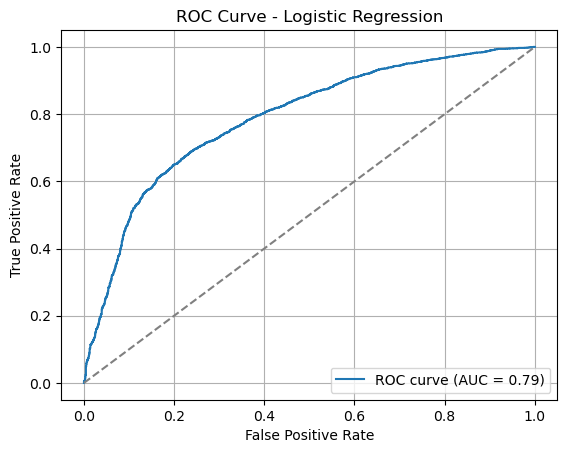

In [4]:
#  ROC Curve and AUC

from sklearn.metrics import roc_curve, auc

y_prob = model.predict_proba(X_val)[:, 1]
fpr, tpr, _ = roc_curve(y_val, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### ROC Curve (AUC = 0.79)
    * AUC of 0.79 indicates good discrimination ability.
    * The model performs much better than random guessing (which would have an AUC of 0.5).
    * AUC close to 0.8 is promising for a baseline model.

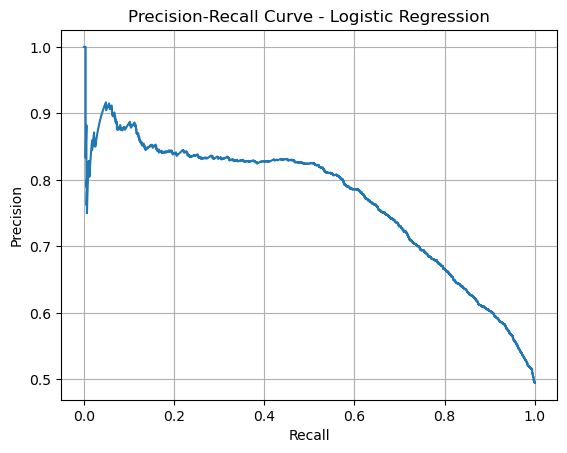

In [5]:
# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_val, y_prob)
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - Logistic Regression")
plt.grid(True)
plt.show()

### Precision-Recall Curve
    * Shows high precision at low recall, which gradually declines.
    * Indicates that as we try to identify more positive cases, precision drops.
    * Useful if you need to balance false positives/negatives differently depending on the application.

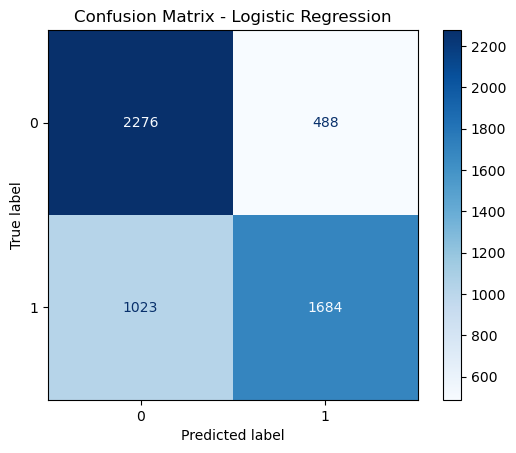

In [6]:
# Confusion Matrix

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

cm = confusion_matrix(y_val, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()

### Confusion Matrix Results
    * True Negatives (2276): Correctly predicted no disease.
    * False Positives (488): Predicted disease, but healthy.
    * False Negatives (1023): Missed actual disease cases.
    * True Positives (1684): Correctly predicted disease.

In [ ]:
# Save feature group to S3
!aws s3 cp cardio_logistic_baseline_v2.ipynb s3://sagemaker-us-east-1-226675648827/sagemaker/feature-store/cardio_engineered_feature_store_setup.ipynb